In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from icecream import ic
from sklearn.preprocessing import LabelEncoder
import time
from itertools import product
from icecream import ic


plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

sales_train = pd.read_csv('./data/sales_train.csv')
test = pd.read_csv('./data/test.csv')   # (214200, 3)

# 计算每个商品每个月的销售量，假如某个商品在某个月没有数据，则填充0（即这个月的销售量为0）
sales_by_item_id = sales_train.pivot_table(index=['item_id'], values=['item_cnt_day'], columns='date_block_num', aggfunc=np.sum, fill_value=0).reset_index()
sales_by_item_id.columns = sales_by_item_id.columns.droplevel().map(str)   # 去掉第一层索引
sales_by_item_id.columns.values[0] = 'item_id'
sales_by_item_id = sales_by_item_id.rename_axis(None, axis=1)

# 获取最近6个月销售量为0的数据
six_zero = sales_by_item_id[(sales_by_item_id['28'] == 0) & (sales_by_item_id['29'] == 0) & (sales_by_item_id['30'] == 0) & (sales_by_item_id['31'] == 0) & (sales_by_item_id['32'] == 0) & (sales_by_item_id['33'] == 0)]
six_zero_item_id = list(six_zero['item_id'].values)   # item_id列表
# test.loc[test.item_id.isin(six_zero_item_id), 'item_cnt_month'] = 0  # 将test数据中（最近六个月销量为0）的数据月销量设为0，有7812个

# 计算每个商店每个月的销量
sales_by_shop_id = sales_train.pivot_table(index=['shop_id'], values=['item_cnt_day'], aggfunc=np.sum, fill_value=0, columns='date_block_num').reset_index()
sales_by_shop_id.columns = sales_by_shop_id.columns.droplevel().map(str)    # 将两层column转化为一层column,保留下层column
sales_by_shop_id.columns.values[0] = 'shop_id'
sales_by_shop_id = sales_by_shop_id.rename_axis(None, axis=1)   # 将列方向的轴重命名为none

# zero = sales_train[sales_train.date_block_num==0]
# ic(zero.shop_id.unique(), len(zero.item_id.unique()), len(zero.shop_id.unique()), len(zero.shop_id.unique()) * len(zero.item_id.unique()))
# ic(sales_train.shop_id.unique(), len(sales_train.item_id.unique()), len(sales_train.shop_id.unique()), len(sales_train.shop_id.unique()) * len(sales_train.item_id.unique()))

"""组合date_block_num,shop_id,item_id(部分) 总量：10913850"""
matrix = []
cols = ['date_block_num','shop_id','item_id']
for i in range(34):
    sales = sales_train[sales_train.date_block_num==i]
    matrix.append(np.array(list(product([i], sales.shop_id.unique(), sales.item_id.unique())), dtype='int16'))
matrix = pd.DataFrame(np.vstack(matrix), columns=cols)
matrix['date_block_num'] = matrix['date_block_num'].astype(np.int8)
matrix['shop_id'] = matrix['shop_id'].astype(np.int8)
matrix.sort_values(cols, inplace=True)  # 排序
sales_train['revenue'] = sales_train['item_price'] * sales_train['item_cnt_day']    # 某一天的销售额

# 分组
groupby = sales_train.groupby(['shop_id','item_id','date_block_num']).agg({'item_cnt_day': 'sum'}).reset_index()
groupby = groupby.rename(columns={'item_cnt_day': 'item_cnt_month'})
matrix = matrix.merge(groupby, on=['date_block_num','shop_id','item_id'], how='left')
matrix['item_cnt_month'] = matrix['item_cnt_month'].fillna(0).clip(0, 20)
matrix['item_cnt_month'] = matrix['item_cnt_month'].astype(np.float16)

# test数据
test['date_block_num'] = 34
test['date_block_num'] = test['date_block_num'].astype(np.int8)
test['shop_id'] = test['shop_id'].astype(np.int8)
test['item_id'] = test['item_id'].astype(np.int16)

# 合并matrix,test
matrix = pd.concat([matrix, test[cols]], ignore_index=True, axis=0)
matrix['item_cnt_month'].fillna(0, inplace=True)

# 商品信息
items = pd.read_csv('./data/items.csv')
items = items[['item_id', 'item_category_id']]
matrix = pd.merge(left=matrix, right=items, on='item_id', how='left')  # 合并

# 商品类别
le = LabelEncoder()
categories = pd.read_csv('./data/item_categories.csv')
categories['split'] = categories['item_category_name'].str.split('-')
categories['type'] = categories['split'].map(lambda x:x[0].strip())
categories['subtype'] = categories['split'].map(lambda x:x[1].strip() if len(x)>1 else x[0].strip())
categories = categories[['item_category_id','type','subtype']]
categories['cat_type_code'] = le.fit_transform(categories['type'])
categories['cat_subtype_code'] = le.fit_transform(categories['subtype'])
matrix = pd.merge(left=matrix, right=categories[['item_category_id','cat_type_code','cat_subtype_code']], on='item_category_id', how='left')    # 合并

# 商店信息
shops = pd.read_csv('./data/shops.csv')
shops['split']=shops.shop_name.str.split(' ')
shops['shop_city'] = shops['split'].map(lambda x:x[0])
shops['shop_city_code'] = le.fit_transform(shops['shop_city'])

def st(name):
    if 'ТЦ' in name or 'ТРЦ' in name:
        shopt = 'ТЦ'
    elif 'ТК' in name:
        shopt = 'ТК'
    elif 'ТРК' in name:
        shopt = 'ТРК'
    elif 'МТРЦ' in name:
        shopt = 'МТРЦ'
    else:
        shopt = 'UNKNOWN'
    return shopt
shops['shop_type'] = shops['shop_name'].apply(st)

shops.loc[shops.shop_id == 21, 'shop_type'] = 'МТРЦ'   # 修正
shops['shop_type_code'] = le.fit_transform(shops['shop_type'])
matrix = pd.merge(left=matrix, right=shops[['shop_id','shop_city_code','shop_type_code']], on='shop_id', how='left')    # 合并
matrix['item_category_id'] = matrix['item_category_id'].astype(np.int8)
matrix['cat_type_code'] = matrix['cat_type_code'].astype(np.int8)
matrix['cat_subtype_code'] = matrix['cat_subtype_code'].astype(np.int8)
matrix['shop_city_code'] = matrix['shop_city_code'].astype(np.int8)
matrix['shop_type_code'] = matrix['shop_type_code'].astype(np.int8)


"""历史信息"""

def lag_features(df, lags, col):
    tmp = df[['date_block_num','shop_id','item_id',col]]
    for i in lags:
        shifted = tmp.copy()
        shifted.columns = ['date_block_num','shop_id','item_id',col+'_lag_'+str(i)]
        shifted['date_block_num'] = shifted['date_block_num'] + i
        df = pd.merge(left=df, right=shifted, on=['date_block_num','shop_id','item_id'], how='left')
    return df

matrix = lag_features(matrix, [1,2,3,6,12], 'item_cnt_month')

# 月销量（所有商品）
group = matrix.groupby('date_block_num').agg({'item_cnt_month': 'mean'}).reset_index()
group.columns = ['date_block_num', 'date_avg_item_cnt']
matrix = pd.merge(left=matrix, right=group, on='date_block_num', how='left')
matrix = lag_features(matrix, [1,2,3,6,12], 'date_avg_item_cnt')
matrix.drop('date_avg_item_cnt', axis=1, inplace=True)

# 月销量（每一件商品）
group = matrix.groupby(['date_block_num', 'item_id']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_item_avg_item_cnt' ]
group.reset_index(inplace=True)
matrix = pd.merge(left=matrix, right=group, on=['date_block_num','item_id'], how='left')
matrix = lag_features(matrix, [1,2,3,6,12], 'date_item_avg_item_cnt')
matrix.drop('date_item_avg_item_cnt', axis=1, inplace=True)

# 月销量（每个商店 ）
group = matrix.groupby(['date_block_num','shop_id']).agg({'item_cnt_month': 'mean'})
group.columns = ['date_shop_avg_item_cnt']
group = group.reset_index()
matrix = pd.merge(left=matrix, right=group, on=['date_block_num','shop_id'], how='left')
matrix = lag_features(matrix, [1,2,3,6,12], 'date_shop_avg_item_cnt')
matrix.drop('date_shop_avg_item_cnt', axis=1, inplace=True)

# 月销量（每个类别）
group = matrix.groupby(['date_block_num','item_category_id']).agg({'item_cnt_month': 'mean'})
group.columns = ['date_cat_avg_item_cnt']
group = group.reset_index()
matrix=pd.merge(left=matrix, right=group, on=['date_block_num','item_category_id'], how='left')
matrix = lag_features(matrix, [1,2,3,6,12], 'date_cat_avg_item_cnt')
matrix.drop('date_cat_avg_item_cnt', axis=1, inplace=True)

# 月销量（商品类别-商店）
group = matrix.groupby(['date_block_num','item_category_id','shop_id']).agg({'item_cnt_month': 'mean'})
group.columns = ['date_cat_shop_avg_item_cnt']
group = group.reset_index()
matrix = pd.merge(left=matrix, right=group, on=['date_block_num','item_category_id','shop_id'], how='left')
matrix = lag_features(matrix, [1,2,3,6,12], 'date_cat_shop_avg_item_cnt')
matrix.drop('date_cat_shop_avg_item_cnt', axis=1, inplace=True)

# 月销量（商品大类）
group = matrix.groupby(['date_block_num','cat_type_code']).agg({'item_cnt_month': 'mean'})
group.columns = ['date_type_avg_item_cnt']
group = group.reset_index()
matrix = pd.merge(left=matrix, right=group, on=['date_block_num','cat_type_code'], how='left')
matrix = lag_features(matrix, [1,2,3,6,12], 'date_type_avg_item_cnt')
matrix.drop('date_type_avg_item_cnt', axis=1, inplace=True)

# 月销量（商品-商品大类） ++++++++++++ 和 月销量（商品）是重复的，因为每一个商品，类别是确定的，大类也是确定的
group = matrix.groupby(['date_block_num', 'item_id', 'cat_type_code']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_item_type_avg_item_cnt']
group = group.reset_index()
matrix = pd.merge(left=matrix, right=group, on=['date_block_num', 'item_id', 'cat_type_code'], how='left')
matrix = lag_features(matrix, [1,2,3,6,12], 'date_item_type_avg_item_cnt')
matrix.drop('date_item_type_avg_item_cnt', axis=1, inplace=True)

# 月销量（商店城市）
group = matrix.groupby(['date_block_num','shop_city_code']).agg({'item_cnt_month': 'mean'})
group.columns = ['date_city_avg_item_cnt']
group = group.reset_index()
matrix = pd.merge(left=matrix, right=group, on=['date_block_num','shop_city_code'], how='left')
matrix = lag_features(matrix, [1,2,3,6,12], 'date_city_avg_item_cnt')
matrix.drop('date_city_avg_item_cnt', axis=1, inplace=True)

# 月销量（商品-商店城市）
group = matrix.groupby(['date_block_num', 'item_id', 'shop_city_code']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_item_city_avg_item_cnt']
group = group.reset_index()
matrix=pd.merge(left=matrix, right=group, on=['date_block_num', 'item_id', 'shop_city_code'], how='left')
matrix = lag_features(matrix, [1,2,3,6,12], 'date_item_city_avg_item_cnt')
matrix.drop('date_item_city_avg_item_cnt', axis=1, inplace=True)

# 趋势特征
group = sales_train.groupby('item_id').agg({'item_price': 'mean'})
group.columns = ['item_avg_item_price']
group = group.reset_index()
matrix = pd.merge(left=matrix, right=group, on='item_id', how='left')

group = sales_train.groupby(['date_block_num','item_id']).agg({'item_price': 'mean'})
group.columns = ['date_item_avg_item_price']
group = group.reset_index()
matrix=pd.merge(left=matrix, right=group, on=['date_block_num','item_id'], how='left')

matrix['item_avg_item_price'] = matrix['item_avg_item_price'].astype(np.float16)
matrix['date_item_avg_item_price'] = matrix['date_item_avg_item_price'].astype(np.float16)

# 计算matrix中商品的历史价格
lags = [1,2,3,4,5,6,12]
matrix = lag_features(matrix, lags, 'date_item_avg_item_price')
for i in lags:
    matrix['delta_price_lag_'+str(i)] = (matrix['date_item_avg_item_price_lag_' + str(i)] - matrix['item_avg_item_price']) / matrix['item_avg_item_price']

def select_trend(row):
    for i in lags:
        if pd.notnull(row['delta_price_lag_'+str(i)]):  # 如果不是NaN
            return row['delta_price_lag_'+str(i)]
    return 0   #  如果delta_price_lag_都为空，那么将趋势设为0，0代表没有趋势

matrix['delta_price_lag'] = matrix.apply(select_trend, axis=1)
matrix['delta_price_lag'] = matrix['delta_price_lag'].astype(np.float16)

features_to_drop = ['item_avg_item_price','date_item_avg_item_price']
for i in lags:
    features_to_drop += ['date_item_avg_item_price_lag_'+str(i)]
    features_to_drop += ['delta_price_lag_'+str(i)]
matrix.drop(features_to_drop, axis=1, inplace=True)

# 每个月的天数
matrix['month'] = matrix['date_block_num'] % 12
days = pd.Series([31,28,31,30,31,30,31,31,30,31,30,31])
matrix['days'] = matrix['month'].map(days)
matrix['days'] = matrix['days'].astype(np.int8)

# 开始销量
matrix['item_shop_first_sale'] = matrix['date_block_num'] - matrix.groupby(['item_id','shop_id'])['date_block_num'].transform('min')
matrix['item_first_sale'] = matrix['date_block_num'] - matrix.groupby('item_id')['date_block_num'].transform('min')

# 因为有12个月的延迟特征（1，2，3，6，12）（1，2，3，4，5，6，12），所以需要删除前12月的数据
matrix = matrix[matrix['date_block_num'] > 11]

# 找到有NaN值的列，然后把那些列中的NaN值填充0
columns = matrix.columns
column_null = []
for i in columns:
    if len(matrix[matrix[i].isnull()]) > 0:
        column_null.append(i)

for i in column_null:
    matrix[i].fillna(0, inplace=True)

In [2]:
matrix

,date_block_num,shop_id,item_id,item_cnt_month,item_category_id,cat_type_code,cat_subtype_code,shop_city_code,shop_type_code,item_cnt_month_lag_1,...,date_item_city_avg_item_cnt_lag_1,date_item_city_avg_item_cnt_lag_2,date_item_city_avg_item_cnt_lag_3,date_item_city_avg_item_cnt_lag_6,date_item_city_avg_item_cnt_lag_12,delta_price_lag,month,days,item_shop_first_sale,item_first_sale
4488756,12,2,27,0.0,19,5,10,1,4,0.0,...,0.0,0.0,0.0,0.0,1.0,-0.282715,0,31,12,12
4488757,12,2,30,0.0,40,11,4,1,4,0.0,...,0.0,0.0,0.0,0.0,0.0,-0.483398,0,31,11,11
4488758,12,2,31,0.0,37,11,1,1,4,0.0,...,0.0,0.0,0.0,0.0,0.0,-0.137451,0,31,11,11
4488759,12,2,32,1.0,40,11,4,1,4,0.0,...,0.0,0.0,0.0,0.0,0.0,-0.407227,0,31,12,12
4488760,12,2,33,1.0,37,11,1,1,4,1.0,...,1.0,2.0,0.0,0.0,1.0,-0.225464,0,31,12,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11128045,34,45,18454,0.0,55,13,2,21,4,1.0,...,0.5,0.0,0.0,0.0,0.0,-0.475098,10,30,11,11
11128046,34,45,16188,0.0,64,14,42,21,4,0.0,...,0.0,0.0,0.0,0.0,0.0,0.081116,10,30,2,2
11128047,34,45,15757,0.0,55,13,2,21,4,0.0,...,0.0,0.5,0.0,0.0,0.0,0.155884,10,30,34,34
11128048,34,45,19648,0.0,40,11,4,21,4,0.0,...,0.0,0.0,0.0,0.0,0.0,-0.091736,10,30,11,11


In [3]:
matrix1 = matrix.copy()
matrix2 = matrix.copy()

#  特征选择 

In [4]:
from sklearn.feature_selection import SelectKBest

In [5]:
trainData = matrix[matrix['date_block_num'] < 33]
label_train = trainData['item_cnt_month']
X_train = trainData.drop('item_cnt_month', axis=1)

validData = matrix[matrix['date_block_num'] == 33]
label_valid = validData['item_cnt_month']
X_valid = validData.drop('item_cnt_month', axis=1)

import lightgbm as lgb
train_data = lgb.Dataset(data=X_train, label=label_train)
valid_data = lgb.Dataset(data=X_valid, label=label_valid)
params = {
    'objective': 'regression',  # 回归
    'metric': 'rmse',   # 回归问题选择rmse
    'n_estimators': 1000,
    'max_depth': 8,
    'num_leaves': 220,   # 每个弱学习器拥有的叶子的数量
    'learning_rate': 0.005,
    'bagging_fraction': 0.9,    # 每次训练“弱学习器”用的数据比例（应该也是随机的），用于加快训练速度和减小过拟合
    'feature_fraction': 0.3,   # 每次迭代过程中，随机选择30%的特征建树（弱学习器）
    'bagging_seed': 0,
    'early_stop_rounds': 50
}
lgb_model = lgb.train(params, train_data, valid_sets=[train_data, valid_data])

d:\program files\python37\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] Unknown parameter: early_stop_rounds
[LightGBM] [Warning] Unknown parameter: early_stop_rounds
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.165826 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10805
[LightGBM] [Info] Number of data points in the train set: 6186922, number of used features: 63
[LightGBM] [Warning] Unknown parameter: early_stop_rounds
[LightGBM] [Info] Start training from score 0.288852
[1]	training's rmse: 1.18562	valid_1's rmse: 1.13456
[2]	training's rmse: 1.18312	valid_1's rmse: 1.13269
[3]	training's rmse: 1.18118	valid_1's rmse: 1.13108
[4]	training's rmse: 1.17929	valid_1's rmse: 1.12975
[5]	training's rmse: 1.1769	valid_1's rmse: 1.12806
[6]	training's rmse: 1.17508	valid_1's rmse: 1.12673
[7]	training's rmse: 1.17298	valid_1's rmse: 1.12502
[8]	training's rmse: 1.1706	valid_1's rmse: 

[140]	training's rmse: 0.975315	valid_1's rmse: 0.987297
[141]	training's rmse: 0.974331	valid_1's rmse: 0.986654
[142]	training's rmse: 0.973621	valid_1's rmse: 0.986152
[143]	training's rmse: 0.972519	valid_1's rmse: 0.985423
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[144]	training's rmse: 0.971613	valid_1's rmse: 0.984871
[145]	training's rmse: 0.970568	valid_1's rmse: 0.984128
[146]	training's rmse: 0.969604	valid_1's rmse: 0.983499
[147]	training's rmse: 0.968692	valid_1's rmse: 0.982924
[148]	training's rmse: 0.968008	valid_1's rmse: 0.982462
[149]	training's rmse: 0.967137	valid_1's rmse: 0.981915
[150]	training's rmse: 0.966207	valid_1's rmse: 0.981332
[151]	training's rmse: 0.965521	valid_1's rmse: 0.980891
[152]	training's rmse: 0.964602	valid_1's rmse: 0.980336
[153]	training's rmse: 0.963772	valid_1's rmse: 0.97983
[154]	training's rmse: 0.963281	valid_1's rmse: 0.979519
[155]	training's rmse: 0.962389	valid_1's rmse: 0.978917
[156]	training

[277]	training's rmse: 0.889787	valid_1's rmse: 0.935162
[278]	training's rmse: 0.889349	valid_1's rmse: 0.934864
[279]	training's rmse: 0.888974	valid_1's rmse: 0.934661
[280]	training's rmse: 0.888626	valid_1's rmse: 0.934452
[281]	training's rmse: 0.888255	valid_1's rmse: 0.934294
[282]	training's rmse: 0.887951	valid_1's rmse: 0.934129
[283]	training's rmse: 0.887614	valid_1's rmse: 0.933984
[284]	training's rmse: 0.887323	valid_1's rmse: 0.93378
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[285]	training's rmse: 0.886967	valid_1's rmse: 0.93359
[286]	training's rmse: 0.886593	valid_1's rmse: 0.933327
[287]	training's rmse: 0.886217	valid_1's rmse: 0.933152
[288]	training's rmse: 0.885798	valid_1's rmse: 0.93287
[289]	training's rmse: 0.885416	valid_1's rmse: 0.93262
[290]	training's rmse: 0.885085	valid_1's rmse: 0.932458
[291]	training's rmse: 0.884723	valid_1's rmse: 0.932267
[292]	training's rmse: 0.884372	valid_1's rmse: 0.932101
[293]	training's 

[401]	training's rmse: 0.854649	valid_1's rmse: 0.918304
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[402]	training's rmse: 0.854475	valid_1's rmse: 0.918215
[403]	training's rmse: 0.854293	valid_1's rmse: 0.918145
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[404]	training's rmse: 0.854112	valid_1's rmse: 0.918055
[405]	training's rmse: 0.85393	valid_1's rmse: 0.917975
[406]	training's rmse: 0.853731	valid_1's rmse: 0.917904
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[407]	training's rmse: 0.853442	valid_1's rmse: 0.917692
[408]	training's rmse: 0.85325	valid_1's rmse: 0.917646
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[409]	training's rmse: 0.853084	valid_1's rmse: 0.917592
[410]	training's rmse: 0.852897	valid_1's rmse: 0.917527
[411]	training's rmse: 0.852711	valid_1's rmse: 0.917502
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[505]	training's rmse: 0.838012	valid_1's rmse: 0.912383
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[506]	training's rmse: 0.837897	valid_1's rmse: 0.912349
[507]	training's rmse: 0.83782	valid_1's rmse: 0.912326
[508]	training's rmse: 0.837704	valid_1's rmse: 0.912291
[509]	training's rmse: 0.837521	valid_1's rmse: 0.912226
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[510]	training's rmse: 0.837408	valid_1's rmse: 0.912199
[511]	training's rmse: 0.837283	valid_1's rmse: 0.912188
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[512]	training's rmse: 0.837142	valid_1's rmse: 0.912115
[513]	training's rmse: 0.837	valid_1's rmse: 0.912047
[514]	training's rmse: 0.836897	valid_1's rmse: 0.911979
[515]	training's rmse: 0.836752	valid_1's rmse: 0.911963
[516]	training's rmse: 0.836616	valid_1's rmse: 0.911939
[517]	training's rms

[603]	training's rmse: 0.826356	valid_1's rmse: 0.909115
[604]	training's rmse: 0.826277	valid_1's rmse: 0.909121
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[605]	training's rmse: 0.826136	valid_1's rmse: 0.909078
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[606]	training's rmse: 0.826026	valid_1's rmse: 0.909055
[607]	training's rmse: 0.825945	valid_1's rmse: 0.909044
[608]	training's rmse: 0.825861	valid_1's rmse: 0.909036
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[609]	training's rmse: 0.825757	valid_1's rmse: 0.909047
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[610]	training's rmse: 0.825675	valid_1's rmse: 0.909066
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[611]	training's rmse: 0.825597	valid_1's rmse: 0.909062
[612]	training's rmse: 0.825492	valid_1's rmse: 0.909052
[LightGBM] [Warning] No further splits with positive ga

[691]	training's rmse: 0.818749	valid_1's rmse: 0.907598
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[692]	training's rmse: 0.818659	valid_1's rmse: 0.907588
[693]	training's rmse: 0.818589	valid_1's rmse: 0.90757
[694]	training's rmse: 0.818531	valid_1's rmse: 0.907598
[695]	training's rmse: 0.818438	valid_1's rmse: 0.907587
[696]	training's rmse: 0.818296	valid_1's rmse: 0.907435
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[697]	training's rmse: 0.818264	valid_1's rmse: 0.907429
[698]	training's rmse: 0.81818	valid_1's rmse: 0.9074
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[699]	training's rmse: 0.818112	valid_1's rmse: 0.907409
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[700]	training's rmse: 0.818045	valid_1's rmse: 0.907412
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[701]	training's rmse: 0.818	valid_1's rmse: 0.907427
[Ligh

[771]	training's rmse: 0.812513	valid_1's rmse: 0.905912
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[772]	training's rmse: 0.812455	valid_1's rmse: 0.905921
[773]	training's rmse: 0.812386	valid_1's rmse: 0.905907
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[774]	training's rmse: 0.812323	valid_1's rmse: 0.905916
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[775]	training's rmse: 0.812242	valid_1's rmse: 0.905872
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[776]	training's rmse: 0.812175	valid_1's rmse: 0.905867
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[777]	training's rmse: 0.812079	valid_1's rmse: 0.905825
[778]	training's rmse: 0.811946	valid_1's rmse: 0.905791
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[779]	training's rmse: 0.811898	valid_1's rmse: 0.905783
[LightGBM] [Warning] No further split

[843]	training's rmse: 0.807752	valid_1's rmse: 0.905456
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[844]	training's rmse: 0.807703	valid_1's rmse: 0.905436
[845]	training's rmse: 0.807634	valid_1's rmse: 0.905406
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[846]	training's rmse: 0.80751	valid_1's rmse: 0.905383
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[847]	training's rmse: 0.807466	valid_1's rmse: 0.905383
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[848]	training's rmse: 0.80741	valid_1's rmse: 0.905389
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[849]	training's rmse: 0.807369	valid_1's rmse: 0.905382
[850]	training's rmse: 0.807223	valid_1's rmse: 0.905223
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[851]	training's rmse: 0.807173	valid_1's rmse: 0.905212
[LightGBM] [Warning] No further splits 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[918]	training's rmse: 0.803375	valid_1's rmse: 0.904279
[919]	training's rmse: 0.803328	valid_1's rmse: 0.904239
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[920]	training's rmse: 0.803277	valid_1's rmse: 0.904215
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[921]	training's rmse: 0.803213	valid_1's rmse: 0.904191
[922]	training's rmse: 0.803167	valid_1's rmse: 0.904173
[923]	training's rmse: 0.803118	valid_1's rmse: 0.904167
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[924]	training's rmse: 0.803087	valid_1's rmse: 0.904174
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[925]	training's rmse: 0.803058	valid_1's rmse: 0.904156
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[926]	training's rmse: 0.803022	valid_1's rmse: 0.904156
[927]	training's rmse: 0.802979	valid

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[989]	training's rmse: 0.800179	valid_1's rmse: 0.903917
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[990]	training's rmse: 0.800157	valid_1's rmse: 0.903915
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[991]	training's rmse: 0.800126	valid_1's rmse: 0.903922
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[992]	training's rmse: 0.800098	valid_1's rmse: 0.903914
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[993]	training's rmse: 0.800065	valid_1's rmse: 0.903907
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[994]	training's rmse: 0.800006	valid_1's rmse: 0.903903
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[995]	training's rmse: 0.799986	valid_1's rmse: 0.903904
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

In [6]:
len(lgb_model.feature_importance())

63

In [7]:
fi = lgb_model.feature_importance()
fi

array([4982, 4790, 6875, 8268, 3666, 6218, 2808, 1952, 3419, 4126, 3155,
       2613, 1820, 4711, 3472, 3334, 1594, 1796, 7409, 5286, 2975, 2163,
       1323, 4600, 3487, 2186, 1911, 1546, 6670, 5519, 3087, 2019, 1203,
       5928, 4355, 3271, 1973, 1387, 7047, 4075, 2300, 1520, 1139, 5169,
       3724, 2467, 1166,  929, 3512, 2214, 1749, 1099,  880, 4935, 3104,
       2375, 1454, 1109, 9016, 6402, 1773, 2793, 3264])

In [11]:
len(fi)

63

In [9]:
sorted_index = np.argsort(-fi)
sorted_index

array([58,  3, 18, 38,  2, 28, 59,  5, 33, 29, 19, 43,  0, 53,  1, 13, 23,
       34,  9, 39, 44,  4, 48, 24, 14,  8, 15, 35, 62, 10, 54, 30, 20,  6,
       61, 11, 45, 55, 40, 49, 25, 21, 31, 36,  7, 26, 12, 17, 60, 50, 16,
       27, 41, 56, 37, 22, 32, 46, 42, 57, 51, 47, 52], dtype=int64)

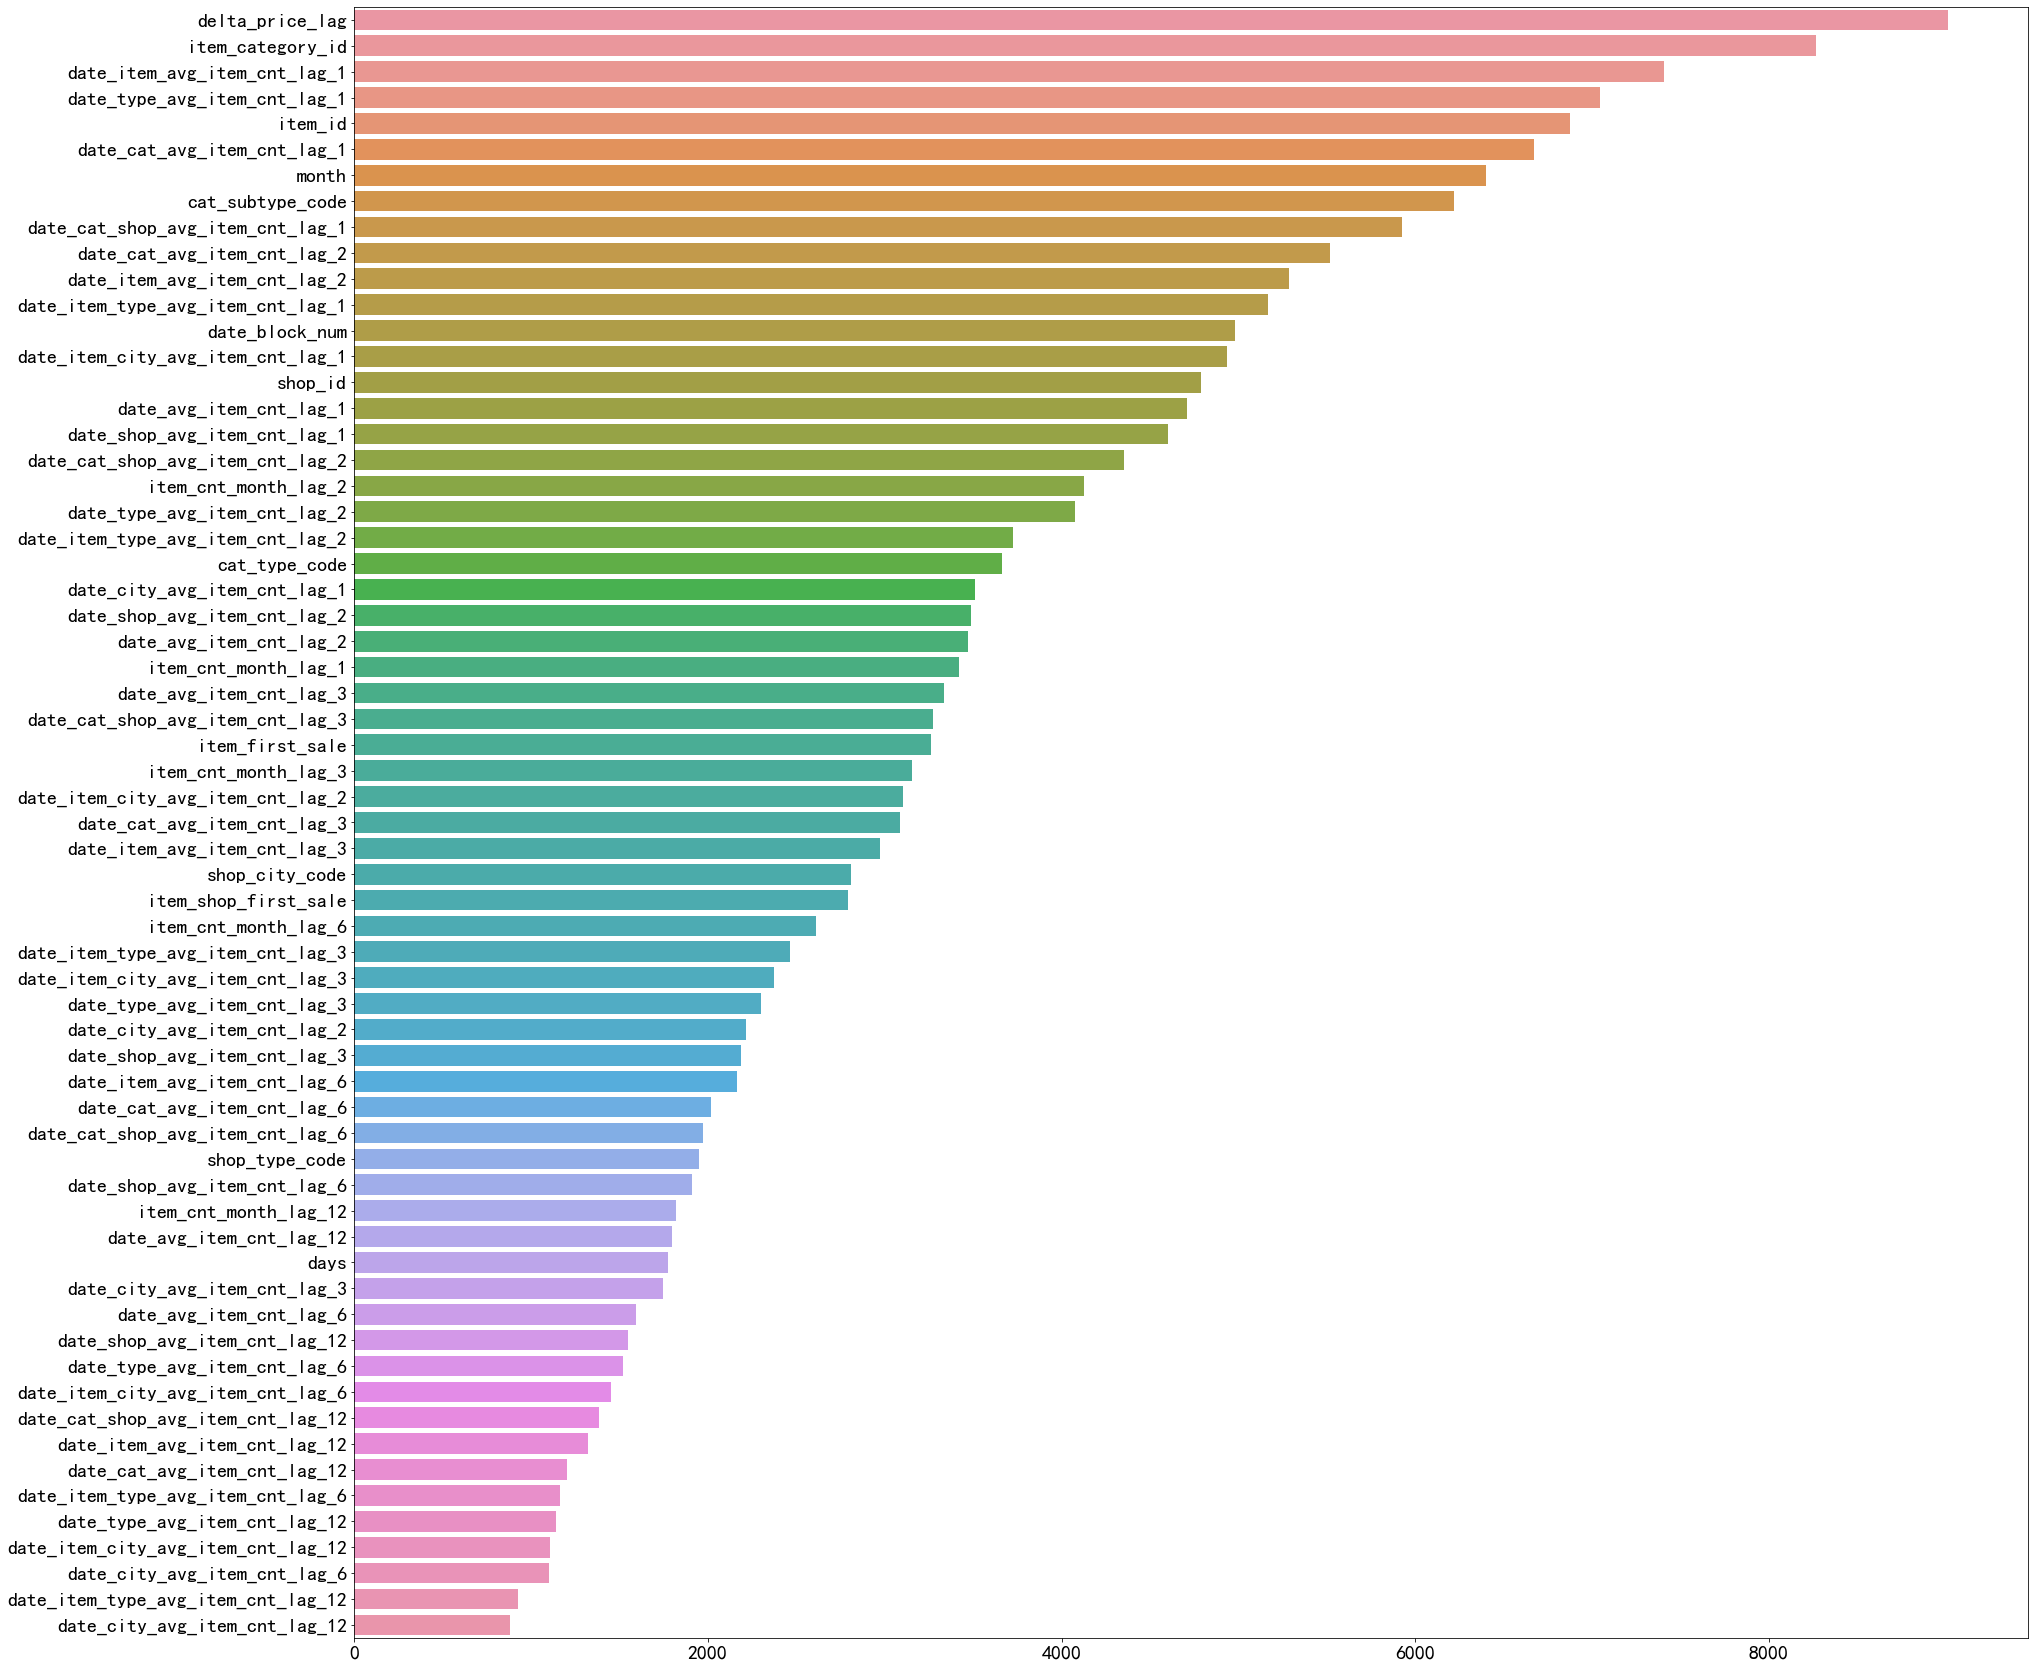

In [10]:
import seaborn as sns
# sns.barplot(x=X_train.columns[sorted_index], y=fi[sorted_index])
plt.style.use({'figure.figsize': (30, 30)})
sns.barplot(x=fi[sorted_index], y=X_train.columns[sorted_index], orient='h')
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.show()

# 建模

In [17]:
# 建模
select_sorted_index = sorted_index[:40]
select_columns = X_train.columns[select_sorted_index]
len(select_columns)

40

In [21]:
select_columns2 =  list(select_columns) + ['item_cnt_month']

In [24]:
matrix_select = matrix[select_columns2]
matrix_select

,delta_price_lag,item_category_id,date_item_avg_item_cnt_lag_1,date_type_avg_item_cnt_lag_1,item_id,date_cat_avg_item_cnt_lag_1,month,cat_subtype_code,date_cat_shop_avg_item_cnt_lag_1,date_cat_avg_item_cnt_lag_2,...,date_cat_avg_item_cnt_lag_3,date_item_avg_item_cnt_lag_3,shop_city_code,item_shop_first_sale,item_cnt_month_lag_6,date_item_type_avg_item_cnt_lag_3,date_item_city_avg_item_cnt_lag_3,date_type_avg_item_cnt_lag_3,date_city_avg_item_cnt_lag_2,item_cnt_month
4488756,-0.282715,19,0.086975,1.034180,27,1.082031,0,10,0.955566,0.765137,...,0.912109,0.130493,1,12,0.0,0.130493,0.0,0.728516,0.100647,0.0
4488757,-0.483398,40,1.021484,0.270020,30,0.291504,0,4,0.046234,0.244873,...,0.236206,0.521973,1,11,0.0,0.521973,0.0,0.209961,0.100647,0.0
4488758,-0.137451,37,0.543457,0.270020,31,0.232788,0,1,0.059448,0.183105,...,0.170776,0.543457,1,11,0.0,0.543457,0.0,0.209961,0.100647,0.0
4488759,-0.407227,40,1.934570,0.270020,32,0.291504,0,4,0.046234,0.244873,...,0.236206,1.260742,1,12,0.0,1.260742,0.0,0.209961,0.100647,1.0
4488760,-0.225464,37,0.913086,0.270020,33,0.232788,0,1,0.059448,0.183105,...,0.170776,0.717285,1,12,0.0,0.717285,0.0,0.209961,0.100647,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11128045,-0.475098,55,0.045441,0.146973,18454,0.196899,10,2,0.126831,0.177612,...,0.217285,0.071411,21,11,0.0,0.071411,0.0,0.163818,0.139038,0.0
11128046,0.081116,64,0.022720,0.237305,16188,0.155884,10,42,0.094482,0.167847,...,0.000000,0.000000,21,2,0.0,0.000000,0.0,0.000000,0.139038,0.0
11128047,0.155884,55,0.113647,0.146973,15757,0.196899,10,2,0.126831,0.177612,...,0.217285,0.095215,21,34,0.0,0.095215,0.0,0.163818,0.139038,0.0
11128048,-0.091736,40,0.045441,0.224243,19648,0.220825,10,4,0.083740,0.200928,...,0.242188,0.166626,21,11,0.0,0.166626,0.0,0.213501,0.139038,0.0


# 训练

In [33]:
trainData = matrix[matrix['date_block_num'] < 33]
label_train = trainData['item_cnt_month']
X_train = trainData.drop('item_cnt_month', axis=1)

validData = matrix[matrix['date_block_num'] == 33]
label_valid = validData['item_cnt_month']
X_valid = validData.drop('item_cnt_month', axis=1)

# 主成分

In [29]:
matrix

,date_block_num,shop_id,item_id,item_cnt_month,item_category_id,cat_type_code,cat_subtype_code,shop_city_code,shop_type_code,item_cnt_month_lag_1,...,date_item_city_avg_item_cnt_lag_1,date_item_city_avg_item_cnt_lag_2,date_item_city_avg_item_cnt_lag_3,date_item_city_avg_item_cnt_lag_6,date_item_city_avg_item_cnt_lag_12,delta_price_lag,month,days,item_shop_first_sale,item_first_sale
4488756,12,2,27,0.0,19,5,10,1,4,0.0,...,0.0,0.0,0.0,0.0,1.0,-0.282715,0,31,12,12
4488757,12,2,30,0.0,40,11,4,1,4,0.0,...,0.0,0.0,0.0,0.0,0.0,-0.483398,0,31,11,11
4488758,12,2,31,0.0,37,11,1,1,4,0.0,...,0.0,0.0,0.0,0.0,0.0,-0.137451,0,31,11,11
4488759,12,2,32,1.0,40,11,4,1,4,0.0,...,0.0,0.0,0.0,0.0,0.0,-0.407227,0,31,12,12
4488760,12,2,33,1.0,37,11,1,1,4,1.0,...,1.0,2.0,0.0,0.0,1.0,-0.225464,0,31,12,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11128045,34,45,18454,0.0,55,13,2,21,4,1.0,...,0.5,0.0,0.0,0.0,0.0,-0.475098,10,30,11,11
11128046,34,45,16188,0.0,64,14,42,21,4,0.0,...,0.0,0.0,0.0,0.0,0.0,0.081116,10,30,2,2
11128047,34,45,15757,0.0,55,13,2,21,4,0.0,...,0.0,0.5,0.0,0.0,0.0,0.155884,10,30,34,34
11128048,34,45,19648,0.0,40,11,4,21,4,0.0,...,0.0,0.0,0.0,0.0,0.0,-0.091736,10,30,11,11


In [31]:
pca_matrix = matrix.copy()
pca_matrix = pca_matrix.drop('item_cnt_month', axis=1)
pca_matrix

,date_block_num,shop_id,item_id,item_category_id,cat_type_code,cat_subtype_code,shop_city_code,shop_type_code,item_cnt_month_lag_1,item_cnt_month_lag_2,...,date_item_city_avg_item_cnt_lag_1,date_item_city_avg_item_cnt_lag_2,date_item_city_avg_item_cnt_lag_3,date_item_city_avg_item_cnt_lag_6,date_item_city_avg_item_cnt_lag_12,delta_price_lag,month,days,item_shop_first_sale,item_first_sale
4488756,12,2,27,19,5,10,1,4,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,-0.282715,0,31,12,12
4488757,12,2,30,40,11,4,1,4,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,-0.483398,0,31,11,11
4488758,12,2,31,37,11,1,1,4,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,-0.137451,0,31,11,11
4488759,12,2,32,40,11,4,1,4,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,-0.407227,0,31,12,12
4488760,12,2,33,37,11,1,1,4,1.0,2.0,...,1.0,2.0,0.0,0.0,1.0,-0.225464,0,31,12,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11128045,34,45,18454,55,13,2,21,4,1.0,0.0,...,0.5,0.0,0.0,0.0,0.0,-0.475098,10,30,11,11
11128046,34,45,16188,64,14,42,21,4,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.081116,10,30,2,2
11128047,34,45,15757,55,13,2,21,4,0.0,0.0,...,0.0,0.5,0.0,0.0,0.0,0.155884,10,30,34,34
11128048,34,45,19648,40,11,4,21,4,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,-0.091736,10,30,11,11


In [32]:
from sklearn.decomposition import PCA
pca = PCA(n_components=30)
pca.fit(pca_matrix)

PCA(n_components=30)

In [37]:
X_train_transform = pca.transform(X_train)
X_valid_transform = pca.transform(X_valid)

In [53]:
train_data = lgb.Dataset(data=X_train, label=label_train)
valid_data = lgb.Dataset(data=X_valid, label=label_valid)
params = {
    'objective': 'regression',  # 回归
    'metric': 'rmse',   # 回归问题选择rmse
    'n_estimators': 1600,
    'max_depth': 8,
    'num_leaves': 200,   # 每个弱学习器拥有的叶子的数量
    'learning_rate': 0.005,
    'bagging_fraction': 1,    # 每次训练“弱学习器”用的数据比例（应该也是随机的），用于加快训练速度和减小过拟合
    'feature_fraction': 0.3,   # 每次迭代过程中，随机选择30%的特征建树（弱学习器）
    'bagging_seed': 0,
    'early_stop_rounds': 50
}
lgb_model = lgb.train(params, train_data, valid_sets=[train_data, valid_data])

[LightGBM] [Warning] Unknown parameter: early_stop_rounds
[LightGBM] [Warning] Unknown parameter: early_stop_rounds
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.193050 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10805
[LightGBM] [Info] Number of data points in the train set: 6186922, number of used features: 63
[LightGBM] [Warning] Unknown parameter: early_stop_rounds
[LightGBM] [Info] Start training from score 0.288852
[1]	training's rmse: 1.18562	valid_1's rmse: 1.13456
[2]	training's rmse: 1.18313	valid_1's rmse: 1.13272
[3]	training's rmse: 1.1812	valid_1's rmse: 1.1311
[4]	training's rmse: 1.17931	valid_1's rmse: 1.12977
[5]	training's rmse: 1.17692	valid_1's rmse: 1.1281
[6]	training's rmse: 1.17511	valid_1's rmse: 1.12677
[7]	training's rmse: 1.17301	valid_1's rmse: 1.12506
[8]	training's rmse: 1.17063	valid_1's rmse: 1

[142]	training's rmse: 0.973981	valid_1's rmse: 0.986371
[143]	training's rmse: 0.972885	valid_1's rmse: 0.985659
[144]	training's rmse: 0.971989	valid_1's rmse: 0.985124
[145]	training's rmse: 0.970946	valid_1's rmse: 0.984375
[146]	training's rmse: 0.969985	valid_1's rmse: 0.983734
[147]	training's rmse: 0.969074	valid_1's rmse: 0.98316
[148]	training's rmse: 0.968392	valid_1's rmse: 0.9827
[149]	training's rmse: 0.967521	valid_1's rmse: 0.982148
[150]	training's rmse: 0.966594	valid_1's rmse: 0.981565
[151]	training's rmse: 0.96591	valid_1's rmse: 0.981129
[152]	training's rmse: 0.964994	valid_1's rmse: 0.980584
[153]	training's rmse: 0.964164	valid_1's rmse: 0.980082
[154]	training's rmse: 0.963675	valid_1's rmse: 0.979766
[155]	training's rmse: 0.962781	valid_1's rmse: 0.979167
[156]	training's rmse: 0.961916	valid_1's rmse: 0.978672
[157]	training's rmse: 0.961329	valid_1's rmse: 0.978275
[158]	training's rmse: 0.96067	valid_1's rmse: 0.977809
[159]	training's rmse: 0.959799	vali

[287]	training's rmse: 0.886823	valid_1's rmse: 0.933477
[288]	training's rmse: 0.886406	valid_1's rmse: 0.933194
[289]	training's rmse: 0.886025	valid_1's rmse: 0.932943
[290]	training's rmse: 0.885692	valid_1's rmse: 0.932781
[291]	training's rmse: 0.885334	valid_1's rmse: 0.932586
[292]	training's rmse: 0.884987	valid_1's rmse: 0.932415
[293]	training's rmse: 0.884552	valid_1's rmse: 0.932179
[294]	training's rmse: 0.88411	valid_1's rmse: 0.931939
[295]	training's rmse: 0.883798	valid_1's rmse: 0.931807
[296]	training's rmse: 0.883446	valid_1's rmse: 0.931655
[297]	training's rmse: 0.883103	valid_1's rmse: 0.931464
[298]	training's rmse: 0.882622	valid_1's rmse: 0.931178
[299]	training's rmse: 0.882259	valid_1's rmse: 0.931036
[300]	training's rmse: 0.881773	valid_1's rmse: 0.930748
[301]	training's rmse: 0.881322	valid_1's rmse: 0.9305
[302]	training's rmse: 0.88092	valid_1's rmse: 0.930301
[303]	training's rmse: 0.88061	valid_1's rmse: 0.930178
[304]	training's rmse: 0.880246	vali

[432]	training's rmse: 0.849324	valid_1's rmse: 0.916145
[433]	training's rmse: 0.849127	valid_1's rmse: 0.9161
[434]	training's rmse: 0.848884	valid_1's rmse: 0.915954
[435]	training's rmse: 0.848655	valid_1's rmse: 0.915841
[436]	training's rmse: 0.848494	valid_1's rmse: 0.91578
[437]	training's rmse: 0.848326	valid_1's rmse: 0.915736
[438]	training's rmse: 0.848207	valid_1's rmse: 0.915682
[439]	training's rmse: 0.848061	valid_1's rmse: 0.915622
[440]	training's rmse: 0.847926	valid_1's rmse: 0.915599
[441]	training's rmse: 0.847755	valid_1's rmse: 0.915509
[442]	training's rmse: 0.847592	valid_1's rmse: 0.915451
[443]	training's rmse: 0.847438	valid_1's rmse: 0.915414
[444]	training's rmse: 0.847283	valid_1's rmse: 0.915383
[445]	training's rmse: 0.847155	valid_1's rmse: 0.915362
[446]	training's rmse: 0.846975	valid_1's rmse: 0.915336
[447]	training's rmse: 0.846823	valid_1's rmse: 0.91529
[448]	training's rmse: 0.846662	valid_1's rmse: 0.91524
[449]	training's rmse: 0.846525	vali

[568]	training's rmse: 0.830999	valid_1's rmse: 0.910505
[569]	training's rmse: 0.830933	valid_1's rmse: 0.910472
[570]	training's rmse: 0.830761	valid_1's rmse: 0.910408
[571]	training's rmse: 0.830615	valid_1's rmse: 0.910306
[572]	training's rmse: 0.830554	valid_1's rmse: 0.91029
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[573]	training's rmse: 0.83048	valid_1's rmse: 0.910301
[574]	training's rmse: 0.830398	valid_1's rmse: 0.91029
[575]	training's rmse: 0.830301	valid_1's rmse: 0.910274
[576]	training's rmse: 0.830224	valid_1's rmse: 0.910274
[577]	training's rmse: 0.830123	valid_1's rmse: 0.91019
[578]	training's rmse: 0.830066	valid_1's rmse: 0.910169
[579]	training's rmse: 0.82993	valid_1's rmse: 0.910109
[580]	training's rmse: 0.829839	valid_1's rmse: 0.910099
[581]	training's rmse: 0.829727	valid_1's rmse: 0.910082
[582]	training's rmse: 0.829546	valid_1's rmse: 0.910007
[583]	training's rmse: 0.82945	valid_1's rmse: 0.910008
[584]	training's rm

[701]	training's rmse: 0.818715	valid_1's rmse: 0.907583
[702]	training's rmse: 0.818635	valid_1's rmse: 0.907568
[703]	training's rmse: 0.818588	valid_1's rmse: 0.907527
[704]	training's rmse: 0.818537	valid_1's rmse: 0.907529
[705]	training's rmse: 0.818349	valid_1's rmse: 0.907503
[706]	training's rmse: 0.818282	valid_1's rmse: 0.907506
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[707]	training's rmse: 0.818233	valid_1's rmse: 0.907523
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[708]	training's rmse: 0.818171	valid_1's rmse: 0.907499
[709]	training's rmse: 0.818096	valid_1's rmse: 0.907493
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[710]	training's rmse: 0.818032	valid_1's rmse: 0.907452
[711]	training's rmse: 0.817979	valid_1's rmse: 0.907435
[712]	training's rmse: 0.817905	valid_1's rmse: 0.907426
[713]	training's rmse: 0.817854	valid_1's rmse: 0.90743
[714]	training's rmse: 0.81779	vali

[817]	training's rmse: 0.810164	valid_1's rmse: 0.905947
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[818]	training's rmse: 0.810143	valid_1's rmse: 0.905942
[819]	training's rmse: 0.809975	valid_1's rmse: 0.906034
[820]	training's rmse: 0.809906	valid_1's rmse: 0.906025
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[821]	training's rmse: 0.809868	valid_1's rmse: 0.906019
[822]	training's rmse: 0.809818	valid_1's rmse: 0.90601
[823]	training's rmse: 0.809749	valid_1's rmse: 0.906094
[824]	training's rmse: 0.809697	valid_1's rmse: 0.906088
[825]	training's rmse: 0.809659	valid_1's rmse: 0.906068
[826]	training's rmse: 0.809536	valid_1's rmse: 0.906018
[827]	training's rmse: 0.809484	valid_1's rmse: 0.906017
[828]	training's rmse: 0.809434	valid_1's rmse: 0.906015
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[829]	training's rmse: 0.809349	valid_1's rmse: 0.906029
[830]	training's rmse: 0.809255	val

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[925]	training's rmse: 0.803704	valid_1's rmse: 0.904743
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[926]	training's rmse: 0.803668	valid_1's rmse: 0.904745
[927]	training's rmse: 0.803633	valid_1's rmse: 0.904748
[928]	training's rmse: 0.803595	valid_1's rmse: 0.904743
[929]	training's rmse: 0.803556	valid_1's rmse: 0.904746
[930]	training's rmse: 0.803509	valid_1's rmse: 0.904751
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[931]	training's rmse: 0.80348	valid_1's rmse: 0.904752
[932]	training's rmse: 0.803443	valid_1's rmse: 0.904743
[933]	training's rmse: 0.80341	valid_1's rmse: 0.904736
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[934]	training's rmse: 0.803369	valid_1's rmse: 0.904726
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[935]	training's rmse: 0.803328	valid_1's rmse: 0.904713


[1017]	training's rmse: 0.799609	valid_1's rmse: 0.904357
[1018]	training's rmse: 0.799517	valid_1's rmse: 0.904279
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1019]	training's rmse: 0.799462	valid_1's rmse: 0.904288
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1020]	training's rmse: 0.799381	valid_1's rmse: 0.904283
[1021]	training's rmse: 0.799342	valid_1's rmse: 0.90428
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1022]	training's rmse: 0.799301	valid_1's rmse: 0.90426
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1023]	training's rmse: 0.799259	valid_1's rmse: 0.904239
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1024]	training's rmse: 0.799222	valid_1's rmse: 0.904244
[1025]	training's rmse: 0.799165	valid_1's rmse: 0.904216
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1026]	training's rmse: 0.7991

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1098]	training's rmse: 0.795981	valid_1's rmse: 0.904007
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1099]	training's rmse: 0.795934	valid_1's rmse: 0.904029
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1100]	training's rmse: 0.795897	valid_1's rmse: 0.904027
[1101]	training's rmse: 0.795873	valid_1's rmse: 0.904016
[1102]	training's rmse: 0.795829	valid_1's rmse: 0.904023
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1103]	training's rmse: 0.795789	valid_1's rmse: 0.904003
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1104]	training's rmse: 0.795755	valid_1's rmse: 0.904037
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1105]	training's rmse: 0.795726	valid_1's rmse: 0.904044
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1106]	trai

[1181]	training's rmse: 0.792657	valid_1's rmse: 0.90351
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1182]	training's rmse: 0.792588	valid_1's rmse: 0.903486
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1183]	training's rmse: 0.792558	valid_1's rmse: 0.9035
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1184]	training's rmse: 0.792534	valid_1's rmse: 0.903496
[1185]	training's rmse: 0.792495	valid_1's rmse: 0.903494
[1186]	training's rmse: 0.792462	valid_1's rmse: 0.903503
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1187]	training's rmse: 0.792414	valid_1's rmse: 0.903469
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1188]	training's rmse: 0.792379	valid_1's rmse: 0.903474
[1189]	training's rmse: 0.792357	valid_1's rmse: 0.903469
[1190]	training's rmse: 0.792317	valid_1's rmse: 0.903458
[LightGBM] [Warning] No further splits with posi

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1256]	training's rmse: 0.789916	valid_1's rmse: 0.903237
[1257]	training's rmse: 0.789861	valid_1's rmse: 0.903246
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1258]	training's rmse: 0.789846	valid_1's rmse: 0.903246
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1259]	training's rmse: 0.789814	valid_1's rmse: 0.903253
[1260]	training's rmse: 0.789786	valid_1's rmse: 0.903286
[1261]	training's rmse: 0.789764	valid_1's rmse: 0.903285
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1262]	training's rmse: 0.789741	valid_1's rmse: 0.903281
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1263]	training's rmse: 0.789721	valid_1's rmse: 0.903279
[1264]	training's rmse: 0.789688	valid_1's rmse: 0.903281
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1265]	training's rmse: 0.78

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1336]	training's rmse: 0.787093	valid_1's rmse: 0.903307
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1337]	training's rmse: 0.787074	valid_1's rmse: 0.903308
[1338]	training's rmse: 0.787019	valid_1's rmse: 0.903292
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1339]	training's rmse: 0.786984	valid_1's rmse: 0.903282
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1340]	training's rmse: 0.786964	valid_1's rmse: 0.903283
[1341]	training's rmse: 0.786942	valid_1's rmse: 0.903288
[1342]	training's rmse: 0.786921	valid_1's rmse: 0.903289
[1343]	training's rmse: 0.786903	valid_1's rmse: 0.903288
[1344]	training's rmse: 0.78686	valid_1's rmse: 0.90328
[1345]	training's rmse: 0.78684	valid_1's rmse: 0.903274
[1346]	training's rmse: 0.786793	valid_1's rmse: 0.903205
[1347]	training's rmse: 0.786761	valid_1's rmse: 0.903205
[LightG

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1413]	training's rmse: 0.7849	valid_1's rmse: 0.902949
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1414]	training's rmse: 0.784884	valid_1's rmse: 0.902948
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1415]	training's rmse: 0.784861	valid_1's rmse: 0.902946
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1416]	training's rmse: 0.784845	valid_1's rmse: 0.902957
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1417]	training's rmse: 0.784822	valid_1's rmse: 0.902966
[1418]	training's rmse: 0.784775	valid_1's rmse: 0.902954
[1419]	training's rmse: 0.784735	valid_1's rmse: 0.902945
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1420]	training's rmse: 0.784716	valid_1's rmse: 0.902946
[1421]	training's rmse: 0.78469	valid_1's rmse: 0.902945
[LightGBM] [Warning] No further

[1494]	training's rmse: 0.782562	valid_1's rmse: 0.902884
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1495]	training's rmse: 0.782541	valid_1's rmse: 0.9029
[1496]	training's rmse: 0.782516	valid_1's rmse: 0.902896
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1497]	training's rmse: 0.782494	valid_1's rmse: 0.902903
[1498]	training's rmse: 0.782474	valid_1's rmse: 0.902926
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1499]	training's rmse: 0.782456	valid_1's rmse: 0.902924
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1500]	training's rmse: 0.782427	valid_1's rmse: 0.902927
[1501]	training's rmse: 0.782397	valid_1's rmse: 0.90293
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1502]	training's rmse: 0.782383	valid_1's rmse: 0.902941
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1503]	training's rmse: 0.78236

[1582]	training's rmse: 0.780369	valid_1's rmse: 0.902782
[1583]	training's rmse: 0.780348	valid_1's rmse: 0.902777
[1584]	training's rmse: 0.780319	valid_1's rmse: 0.902781
[1585]	training's rmse: 0.780296	valid_1's rmse: 0.902774
[1586]	training's rmse: 0.780274	valid_1's rmse: 0.902767
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1587]	training's rmse: 0.780251	valid_1's rmse: 0.902766
[1588]	training's rmse: 0.780237	valid_1's rmse: 0.902765
[1589]	training's rmse: 0.780122	valid_1's rmse: 0.902839
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1590]	training's rmse: 0.78011	valid_1's rmse: 0.902837
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1591]	training's rmse: 0.780094	valid_1's rmse: 0.902845
[1592]	training's rmse: 0.780051	valid_1's rmse: 0.902834
[1593]	training's rmse: 0.780029	valid_1's rmse: 0.902826
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1594

# 验证 

In [54]:
from sklearn.metrics import mean_squared_error
valid_prediction = lgb_model.predict(X_valid).clip(0,20)
rmse_valid = np.sqrt(mean_squared_error(valid_prediction, label_valid))
rmse_valid

0.902776930417804

In [55]:
# test数据
testData = matrix[matrix['date_block_num'] == 34]
X_test = testData.drop('item_cnt_month', axis=1)

# 预测&生成文件
y_test = lgb_model.predict(X_test).clip(0, 20)
submission = pd.DataFrame({ 'ID': range(0, 214200), 'item_cnt_month': y_test})

test0 = test[test.item_id.isin(six_zero_item_id)]
ids = list(test0.ID.values)
submission.loc[submission.ID.isin(ids), 'item_cnt_month'] = 0.0
submission.to_csv('./submit/sub13.csv', index=False)